# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
# from google.colab import drive

# drive.mount("/gdrive")
# %cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [3]:
data = np.load("/kaggle/input/mars-for-student/mars_for_students.npz")
# data = np.load("mars_cleaned_and_augmented.npz")

#X_train = data['X_train']
#y_train = data['y_train']

#X_test = data["X_test"]

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# find the number of occurences similar to the image at index 348 in the training set
# Compare all the image in y_train with the image at index 348, if they are equal, add the index to a list and increment a counter
index = 348
similar_images = []
for i, image in enumerate(y_train):
    if np.array_equal(image, y_train[index]):
        similar_images.append(i)
        
print(f"Number of similar images: {len(similar_images)}")

# Remove all the corrupted data in y_train and X_train and register a new dataset 
X_train = np.delete(X_train, similar_images, axis=0)
y_train = np.delete(y_train, similar_images, axis=0)

X_train = tf.clip_by_value(X_train[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)
y_train = y_train[..., np.newaxis]
X_test  = tf.clip_by_value(X_test[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Number of similar images: 110
Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


## Prepare the data


In [4]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
LEARNING_RATE = 5e-3
EPOCHS = 1000
PATIENCE = 30
BATCH_SIZE = 64 
SPLITS_SIZE = 300
SEED = 42
NUM_CLASSES = 5

X_train = X_train.numpy() if isinstance(X_train, tf.Tensor) else np.array(X_train)
y_train = y_train.numpy() if isinstance(y_train, tf.Tensor) else np.array(y_train)

from sklearn.model_selection import train_test_split

#train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
#    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
#)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)


print(f"Train set shape: {train_img.shape}")
print(f"Validation image set shape: {val_img.shape}")
print(f"Validation masks set shape: {val_lbl.shape}")
# print(f"Test set shape: {test_img.shape}")




Train set shape: (2205, 64, 128, 1)
Validation image set shape: (300, 64, 128, 1)
Validation masks set shape: (300, 64, 128, 1)


## Augmentation

In [6]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#test_dataset = make_dataset(
#    test_img, test_lbl,
#    batch_size=BATCH_SIZE,
#    shuffle=False
#)
print("Datasets created!")

def remove_extra_dim(images, labels):
    labels = tf.squeeze(labels, axis=-1)  # Supprime la dimension supplémentaire
    return images, labels

train_dataset = train_dataset.map(remove_extra_dim)

val_dataset = val_dataset.map(remove_extra_dim)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break




Creating datasets...


/tmp/ipykernel_1183/3033776155.py:120: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
/tmp/ipykernel_1183/3033776155.py:120: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
/tmp/ipykernel_1183/3033776155.py:120: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)


WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'float32'>


## Metric for simulation

In [8]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=(64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Model

Model: "ELAD"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 64,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MV2Block_s1_b1      │ (None, 32, 64,    │        848 │ conv2d[0][0]      │
│ (Functional)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MV2Block_s2_b21     │ (None, 16, 32,    │      1,168 │ MV2Block_s1_b1[0… │
│ (Functional)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MV2Block_s1_b22     │ (None, 16, 32,    │      2,720 │ MV2Block_s2_b21[… │
│ (Functional)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MV2Block_s2_b3      │ (None, 8, 16, 64) │      3,872 │ MV2Block_s1_b22[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 16,     │     73,856 │ MV2Block_s2_b3[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 16,     │     16,512 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 128)  │          0 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 128)  │        256 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128)  │          0 │ reshape[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128)  │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 128)  │          0 │ add_2[0][0],      │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 5,979,589 (22.81 MB)

 Trainable params: 5,977,573 (22.80 MB)

 Non-trainable params: 2,016 (7.88 KB)

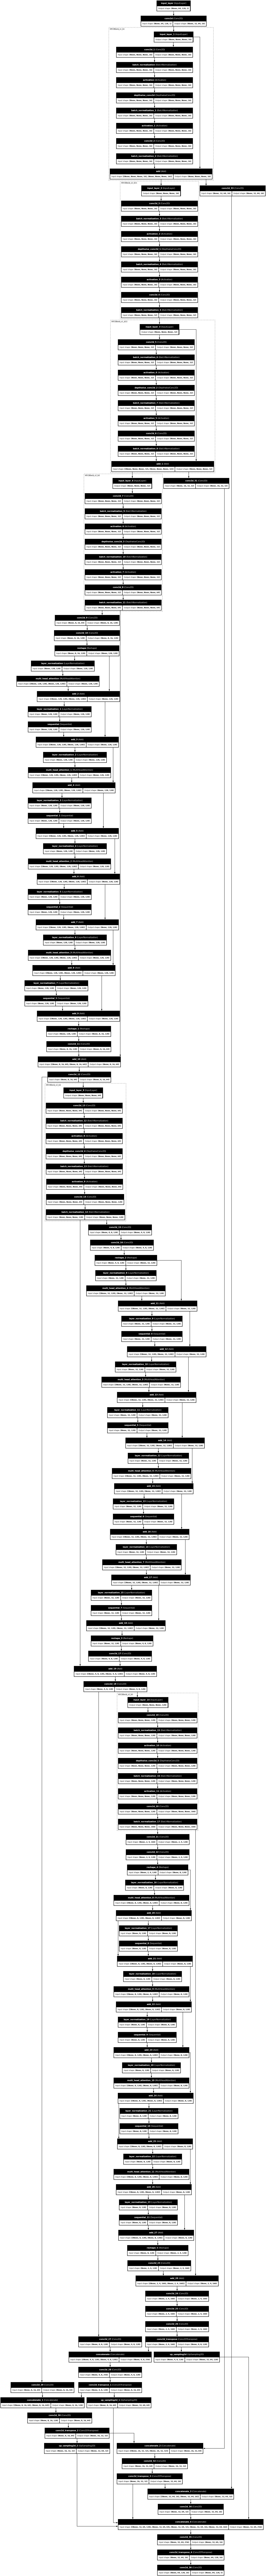

In [9]:
def MV2Block(input_channels, output_channels, stride=1, block_id=0):
    """
    Implémentation d'un bloc MobileNetV2 (MV2).

    Arguments :
    - input_channels : Nombre de canaux en entrée.
    - output_channels : Nombre de canaux en sortie.
    - stride : Stride pour la convolution depthwise (1 ou 2).
    - block_id : Identifiant unique pour le bloc.

    Retourne :
    - Un bloc MV2 en tant que modèle Keras fonctionnel.
    """
    inputs = tfkl.Input(shape=(None, None, input_channels))

    # Convolution 1x1 (Pointwise), suivie de BN et SiLU
    x = tfkl.Conv2D(input_channels, kernel_size=1, strides=1, padding='same', use_bias=False)(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('swish')(x)  # SiLU activation

    # Convolution Depthwise 3x3
    x = tfkl.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('swish')(x)  # SiLU activation

    # Convolution 1x1 (Pointwise) pour réduction des dimensions
    x = tfkl.Conv2D(output_channels, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)

    # Si stride == 1, on applique un shortcut connection
    if stride == 1 and input_channels == output_channels:
        x = tfkl.Add()([inputs, x])

    return tf.keras.Model(inputs, x, name=f"MV2Block_s{stride}_b{block_id}")

def transformer_block(inputs, num_heads, projection_dim, transformer_layers):
    """
    Implements the transformer block with multi-head self-attention and feedforward layers.
    """
    x = inputs
    for _ in range(transformer_layers):
        # Layer Normalization
        x1 = tfkl.LayerNormalization(epsilon=1e-6)(x)
        # Multi-head self-attention
        attention_output = tfkl.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        # Skip connection
        x2 = tfkl.Add()([x, attention_output])
        # Feedforward
        x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)
        ff_output = tfk.Sequential([
            tfkl.Dense(4 * projection_dim, activation='gelu'),
            tfkl.Dense(projection_dim),
        ])(x3)
        # Skip connection
        x = tfkl.Add()([x2, ff_output])
    return x

def mvvit_block(input_tensor, num_heads, projection_dim, transformer_layers, block_id=0):
    """
    Implements the MViT block as shown in the diagram.
    """
    # Convolutional path
    x_conv = tfkl.Conv2D(filters=projection_dim, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x_conv = tfkl.Conv2D(filters=projection_dim, kernel_size=1, padding='same', activation='relu')(x_conv)

    # Flatten for transformer input (reshape to [N, P, d])
    batch_size, height, width, channels = tf.keras.backend.int_shape(x_conv)
    x_flatten = tfkl.Reshape((height * width, projection_dim))(x_conv)
    # Transformer for global representation
    x_transformer = transformer_block(x_flatten, num_heads, projection_dim, transformer_layers)

    # Reshape back to spatial dimensions
    x_reshaped = tfkl.Reshape((height, width, projection_dim))(x_transformer)

    # Convolution to merge outputs
    x_merge = tfkl.Conv2D(filters=input_tensor.shape[-1], kernel_size=1, padding='same')(x_reshaped)

    # Skip connection
    x_skip = tfkl.Add()([input_tensor, x_merge])

    # Final convolution to project back to HxWxC
    output = tfkl.Conv2D(filters=input_tensor.shape[-1], kernel_size=3, padding='same')(x_skip)

    return output

def LightweightEncoder(input_shape, mv2_channels, mvit_params):
    """
    Implements the Lightweight Encoder from the provided diagram.

    Arguments:
    - input_shape: Shape of the input tensor (H, W, C).
    - mv2_channels: List of output channels for each MV2Block stage.
    - mvit_params: Dictionary containing the parameters for the MViT blocks (e.g., heads, dim, layers).

    Returns:
    - A Keras Model implementing the Lightweight Encoder.
    - Outputs of each stage.
    """
    inputs = tfk.Input(shape=input_shape)

    # Stage 1
    x = tfkl.Conv2D(filters=mv2_channels[0], kernel_size=3, strides=2, padding='same', activation='relu')(inputs)  # Downsample by 2
    x = MV2Block(input_channels=mv2_channels[0], output_channels=mv2_channels[0], block_id=1)(x)
    F1 = x  # Output of Stage 1

    # Stage 2
    x = MV2Block(input_channels=mv2_channels[0], output_channels=mv2_channels[1], stride=2, block_id=21)(x)  # Downsample by 2
    x = MV2Block(input_channels=mv2_channels[1], output_channels=mv2_channels[1], block_id=22)(x)
    F2 = x  # Output of Stage 2

    # Stage 3
    x = MV2Block(input_channels=mv2_channels[1], output_channels=mv2_channels[2], stride=2, block_id=3)(x)  # Downsample by 2
    x = mvvit_block(x,
                    num_heads=mvit_params['num_heads'],
                    projection_dim=mvit_params['projection_dim'],
                    transformer_layers=mvit_params['transformer_layers'],
                    block_id=3)
    # x = tfkl.Conv2D(filters=mv2_channels[2], kernel_size=1, strides=1, padding='same')(x)
    F3 = x  # Output of Stage 3

    # Stage 4
    x = MV2Block(input_channels=mv2_channels[2], output_channels=mv2_channels[3], stride=2, block_id=4)(x)  # Downsample by 2
    x = mvvit_block(x,
                    num_heads=mvit_params['num_heads'],
                    projection_dim=mvit_params['projection_dim'],
                    transformer_layers=mvit_params['transformer_layers'],
                    block_id=4)
   # x = tfkl.Conv2D(filters=mv2_channels[3], kernel_size=1, strides=1, padding='same')(x)
    F4 = x  # Output of Stage 4

    # Stage 5
    
    x = MV2Block(input_channels=mv2_channels[3], output_channels=mv2_channels[4], stride=2, block_id=5)(x)  # Downsample by 2
    x = mvvit_block(x,
                    num_heads=mvit_params['num_heads'],
                    projection_dim=mvit_params['projection_dim'],
                    transformer_layers=mvit_params['transformer_layers'],
                    block_id=5)
    x = tfkl.Conv2D(filters=mv2_channels[4], kernel_size=1, strides=1, padding='same')(x)
    F5 = x  # Output of Stage 5
    
    # Model
    encoder_model = tfk.Model(inputs, [F1, F2, F3, F4, F5], name="LightweightEncoder")
    return encoder_model

def CFF(input_tensor_i, input_tensor_i_plus_1, filters):
    """
    Cross-Feature Fusion (CFF) module.

    Arguments:
    - input_tensor_i: Input tensor from encoder stage i.
    - input_tensor_i_plus_1: Input tensor from encoder stage i+1.
    - filters: Number of filters for the 1x1 convolutions.

    Returns:
    - Two output tensors:
        1. The upsampled tensor from stage i+1.
        2. The fused tensor after concatenation and 1x1 convolution.
    """
    # Upsample the input tensor from stage i+1 by a factor of 2
    #upsampled_i_plus_1 = tfkl.UpSampling2D(size=(2, 2))(input_tensor_i_plus_1)

    upsampled_i_plus_1 = tfkl.Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(input_tensor_i_plus_1)
    
    # Apply 1x1 convolution to the input tensor from stage i
    conv_i = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor_i)

    # Concatenate the upsampled tensor from stage i+1 and the convolved tensor from stage i
    concatenated = tfkl.Concatenate()([upsampled_i_plus_1, conv_i])

    # Apply another 1x1 convolution to the concatenated tensor
    fused = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(concatenated)

    return upsampled_i_plus_1, fused


def CFA(feature_maps, filters):
    """
    Compact Feature Aggregation (CFA) module.

    Arguments:
    - feature_maps: List of feature maps from CFF modules.
    - filters: Number of filters for the 1x1 convolution.

    Returns:
    - Fused feature map.
    """
    # Reshape high-level feature maps to the same size as the lowest resolution feature map
    reshaped_feature_maps = []
    for feature_map in feature_maps[:3]:
        reshaped_feature_map = tfkl.UpSampling2D(size=(2 ** (3 - feature_maps.index(feature_map))))(feature_map)
        reshaped_feature_maps.append(reshaped_feature_map)

    for feature_map in feature_maps[3:]:
        reshaped_feature_maps.append(feature_map)
    # Concatenate all feature maps
    concatenated = tfkl.Concatenate()(reshaped_feature_maps)

    # Apply 1x1 convolution for feature fusion
    fused = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(concatenated)
    
    # Final 2* upsample to the original input size
    output = tfkl.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same', activation='relu')(fused)

    return output


def ELAD(encoder_model, num_classes, mv2_channels):
    """
    Efficient Lightweight Aggregation Decoder (ELAD).

    Arguments:
    - encoder_model: The encoder model.
    - num_classes: Number of classes for the segmentation task.
    - mv2_channels: List of output channels for each MV2Block stage.

    Returns:
    - A Keras Model implementing the ELAD.
    """
    encoder_outputs = encoder_model.output
    F1, F2, F3, F4, F5 = encoder_outputs
    #print(F1.shape, F2.shape, F3.shape, F4.shape, F5.shape)

    # conv1x1 to reduce the number of channels
    F5 = tfkl.Conv2D(filters=mv2_channels[4], kernel_size=1, padding='same', activation='relu')(F5)
    
    # Apply CFF modules
    C5, fused_F4_F3 = CFF(F4, F5, mv2_channels[3])
    C4, fused_F3_F2 = CFF(F3, fused_F4_F3, mv2_channels[2])
    C3, fused_F2_F1 = CFF(F2, fused_F3_F2, mv2_channels[1])
    C2, fused_F1 = CFF(F1, fused_F2_F1, mv2_channels[0])

    # Collect all feature maps for CFA
    feature_maps = [C5, C4, C3, C2, fused_F1]

    # Apply CFA module
    fused_features = CFA(feature_maps, mv2_channels[0])

    # Final convolution to project to the number of classes
    output = tfkl.Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='softmax')(fused_features)

    # Model
    return tfk.Model(encoder_model.input, output, name="ELAD")

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def Unet_decoder(encoder_model, num_classes, mv2_channels):
    """
    U-Net decoder for semantic segmentation.

    Arguments:
    - encoder_model: The encoder model.
    - num_classes: Number of classes for the segmentation task.
    - mv2_channels: List of output channels for each MV2Block stage.

    Returns:
    - A Keras Model implementing the U-Net decoder.
    """
    encoder_outputs = encoder_model.output
    F1, F2, F3, F4 = encoder_outputs

    bottleneck = unet_block(F4, mv2_channels[3], name='bottleneck')
    
    # Upsampling path
    upsampled_1 = tfkl.UpSampling2D(size=(2, 2))(bottleneck)
    upsampled_1 = tfkl.Concatenate()([upsampled_1, F3])
    upsampled_1 = unet_block(upsampled_1, mv2_channels[2], name='up1')
    
    upsampled_2 = tfkl.UpSampling2D(size=(2, 2))(upsampled_1)
    upsampled_2 = tfkl.Concatenate()([upsampled_2, F2])
    upsampled_2 = unet_block(upsampled_2, mv2_channels[1], name='up2')
    
    upsampled_3 = tfkl.UpSampling2D(size=(2, 2))(upsampled_2)
    upsampled_3 = tfkl.Concatenate()([upsampled_3, F1])
    upsampled_3 = unet_block(upsampled_3, mv2_channels[0], name='up3')
    
    # Final convolution to project to the number of classes
    output = tfkl.Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='softmax')(upsampled_3)
    # Model
    return tfk.Model(encoder_model.input, output, name="Unet_decoder")

def SegMarsViT(input_shape, mv2_channels, mvit_params, num_classes):
    """
    Creates the SegMarsViT model.

    Arguments:
    - input_shape: Shape of the input tensor (H, W, C).
    - mv2_channels: List of output channels for each MV2Block stage.
    - mvit_params: Dictionary containing the parameters for the MViT blocks (e.g., heads, dim, layers).
    - num_classes: Number of classes for the segmentation task.

    Returns:
    - A Keras Model implementing the SegMarsViT.
    """
    # Create the Lightweight Encoder
    encoder_model = LightweightEncoder(input_shape, mv2_channels, mvit_params)

    # Create the ELAD Decoder
    model = ELAD(encoder_model, num_classes, mv2_channels)

    return model

# Parameters for the encoder
input_shape = (64, 128, 1)  # Example input shape (H, W, C)
mvit_params = {
    'num_heads': 4,
    'projection_dim': 64*2,
    'transformer_layers': 4
}

# Define the mv2_channels list for different network sizes
mv2_channels_s = [16, 32, 64, 128, 160]
mv2_channels_xs = [16, 24, 48, 80, 96]
mv2_channels_xxs = [16, 16, 24, 48, 64]

# Create the SegMarsViT models for different network sizes
model = SegMarsViT(input_shape, mv2_channels_s, mvit_params, NUM_CLASSES)


model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=70)

## Loss

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def weighted_iou_loss(y_true, y_pred, epsilon=1e-6):
    """
    Computes the weighted IoU loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.
    - epsilon: Small constant to avoid division by zero.

    Returns:
    - Weighted IoU loss.
    """
    
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # 5 classes pour la segmentation

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return 1 - iou

def weighted_bce_loss(y_true, y_pred):
    """
    Computes the weighted BCE loss.

    Arguments:
    - y_true: Ground truth labels.
    - y_pred: Predicted probabilities.

    Returns:
    - Weighted BCE loss.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0)
    return bce(y_true, y_pred)

def custom_loss(y_true, y_pred):
    """
    Computes the combined weighted IoU and BCE loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.

    Returns:
    - Combined weighted IoU and BCE loss.
    """
    print(y_true.shape,y_pred.shape )
    iou_loss = weighted_iou_loss(y_true, y_pred)
    bce_loss = weighted_bce_loss(y_true, y_pred)
    return iou_loss + bce_loss


# from the document but how to use it ?
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union


In [11]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = LEARNING_RATE  # Taux d'apprentissage initial
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=6*BATCH_SIZE,  # Nombre d'epochs ou de batches avant que le taux d'apprentissage diminue
    decay_rate=0.9,     # Facteur par lequel le taux d'apprentissage diminue chaque fois
    staircase=True       # Si True, le taux d'apprentissage est mis à jour après chaque étape (et non pas de manière continue)
)

# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


model.compile(
    loss=custom_loss,
    optimizer=optimizer,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

Epoch 1/1000
(None, 64, 128) (None, 64, 128, 5)
(None, 64, 128) (None, 64, 128, 5)


I0000 00:00:1734116911.069980    1224 service.cc:145] XLA service 0x7ce324011630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734116911.070039    1224 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734116911.070043    1224 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734116919.847071    1224 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734116932.936427    1329 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_124', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00:1734116940.023817    1329 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_501', 256 bytes spill stores, 256 bytes spill loads

I0000

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2721 - loss: 3.1481 - mean_iou: 0.1174

W0000 00:00:1734117022.263836    1223 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734117048.920469    1532 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 776 bytes spill stores, 776 bytes spill loads

I0000 00:00:1734117056.200800    1529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_120', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1734117056.885866    1530 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_102', 836 bytes spill stores, 836 bytes spill loads

I0000 00:00:1734117057.069535    1531 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_98', 836 bytes spill stores, 836 bytes spill loads

I0000 00:00:173411

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2728 - loss: 3.1308 - mean_iou: 0.1175   

I0000 00:00:1734117098.871105    1223 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_48', 72 bytes spill stores, 72 bytes spill loads



(None, 64, 128) (None, 64, 128, 5)


W0000 00:00:1734117107.464200    1221 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734117121.479376    1222 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734117127.615788    1696 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_109', 256 bytes spill stores, 256 bytes spill loads



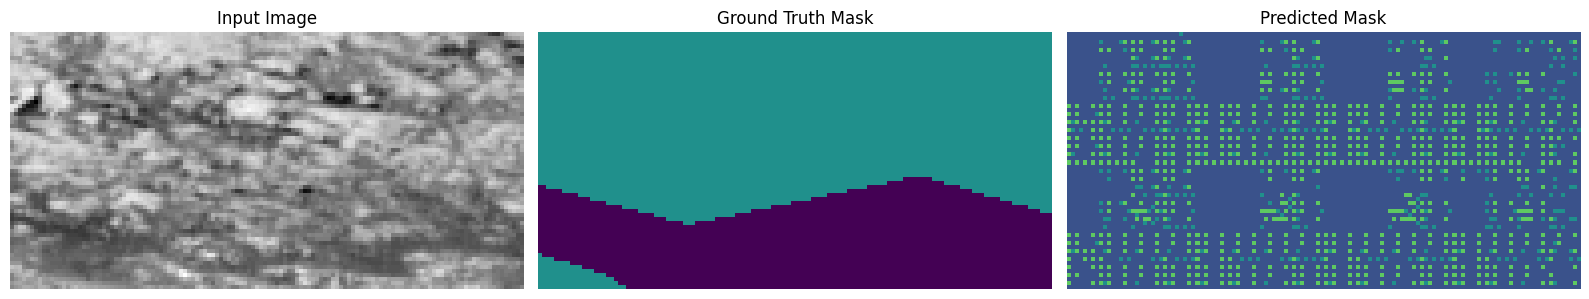

35/35 ━━━━━━━━━━━━━━━━━━━━ 288s 4s/step - accuracy: 0.2734 - loss: 3.1145 - mean_iou: 0.1176 - val_accuracy: 0.3247 - val_loss: 2.0983 - val_mean_iou: 0.1345
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.3342 - loss: 1.9296 - mean_iou: 0.1075 - val_accuracy: 0.3408 - val_loss: 1.9225 - val_mean_iou: 0.1159
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.3341 - loss: 1.9178 - mean_iou: 0.1544 - val_accuracy: 0.3090 - val_loss: 1.9295 - val_mean_iou: 0.1347
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.3311 - loss: 1.9316 - mean_iou: 0.1243 - val_accuracy: 0.3399 - val_loss: 1.9386 - val_mean_iou: 0.1167
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.3417 - loss: 1.9057 - mean_iou: 0.1389 - val_accuracy: 0.3426 - val_loss: 1.9164 - val_mean_iou: 0.1131
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.3689 - loss: 1.8744 - mean_iou: 0.1833

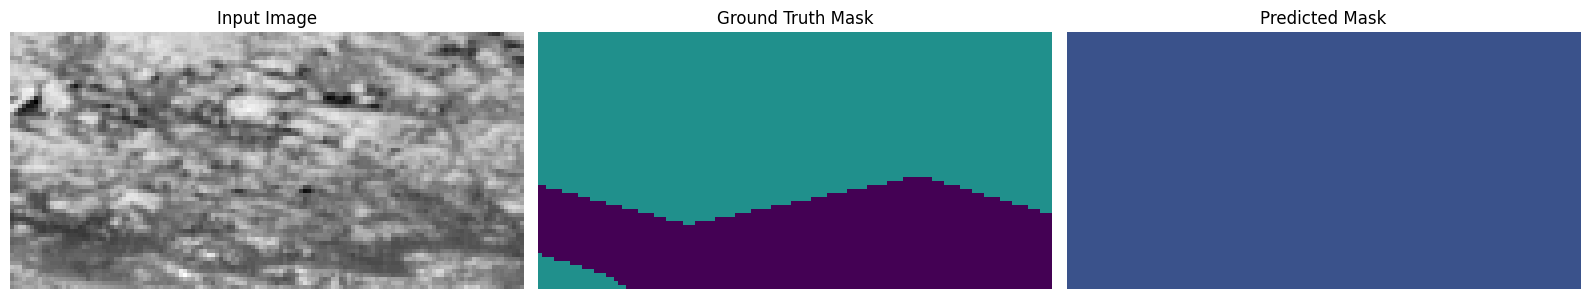

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.3687 - loss: 1.8748 - mean_iou: 0.1831 - val_accuracy: 0.3428 - val_loss: 1.9324 - val_mean_iou: 0.1129
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.3354 - loss: 1.8975 - mean_iou: 0.1235 - val_accuracy: 0.3410 - val_loss: 1.9220 - val_mean_iou: 0.1142
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.3422 - loss: 1.8858 - mean_iou: 0.1251 - val_accuracy: 0.3428 - val_loss: 1.9791 - val_mean_iou: 0.1130
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.3533 - loss: 1.8532 - mean_iou: 0.1586 - val_accuracy: 0.3424 - val_loss: 2.0664 - val_mean_iou: 0.1134
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.3790 - loss: 1.7557 - mean_iou: 0.2175 - val_accuracy: 0.2504 - val_loss: 2.0325 - val_mean_iou: 0.1143
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.3975 - loss: 1.7022 - mean_iou: 0.2389

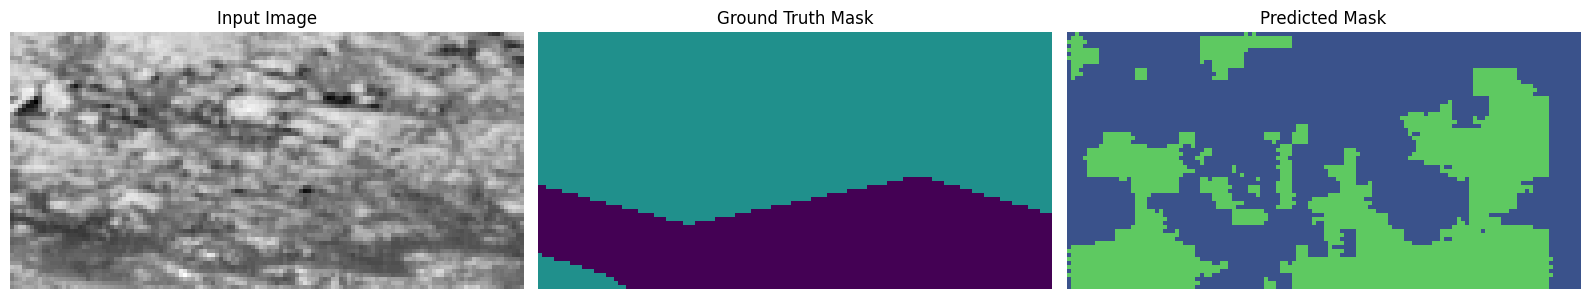

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.3975 - loss: 1.7016 - mean_iou: 0.2393 - val_accuracy: 0.3388 - val_loss: 1.9103 - val_mean_iou: 0.1729
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.4143 - loss: 1.6541 - mean_iou: 0.2484 - val_accuracy: 0.4057 - val_loss: 1.7443 - val_mean_iou: 0.2104
Epoch 13/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.4198 - loss: 1.6268 - mean_iou: 0.2563 - val_accuracy: 0.4174 - val_loss: 1.7278 - val_mean_iou: 0.2202
Epoch 14/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.4209 - loss: 1.6211 - mean_iou: 0.2586 - val_accuracy: 0.4288 - val_loss: 1.6485 - val_mean_iou: 0.2450
Epoch 15/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.4235 - loss: 1.6220 - mean_iou: 0.2623 - val_accuracy: 0.4459 - val_loss: 1.5688 - val_mean_iou: 0.2612
Epoch 16/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4281 - loss: 1.5947 - mean_iou: 0.2666

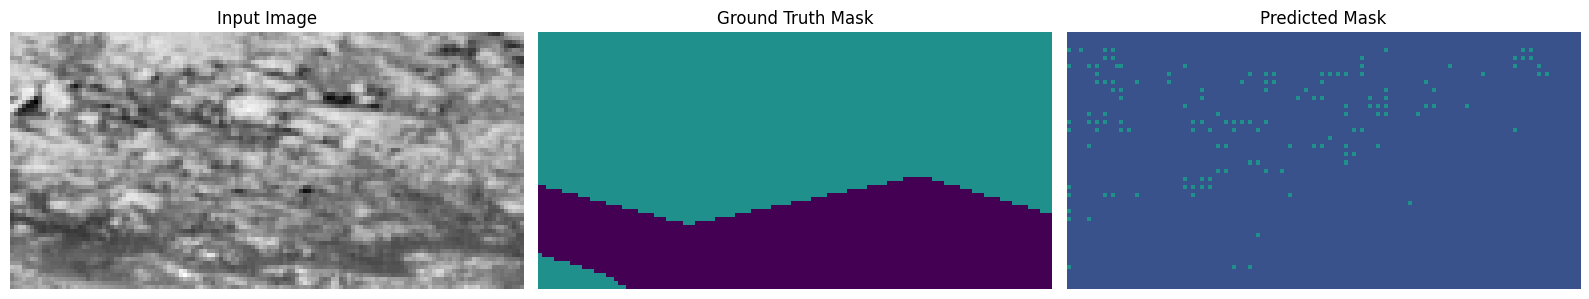

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.4281 - loss: 1.5946 - mean_iou: 0.2669 - val_accuracy: 0.3787 - val_loss: 1.8771 - val_mean_iou: 0.1744
Epoch 17/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.4285 - loss: 1.5799 - mean_iou: 0.2758 - val_accuracy: 0.3564 - val_loss: 2.0058 - val_mean_iou: 0.1688
Epoch 18/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.4263 - loss: 1.5909 - mean_iou: 0.2669 - val_accuracy: 0.4194 - val_loss: 1.7361 - val_mean_iou: 0.2186
Epoch 19/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.4301 - loss: 1.5842 - mean_iou: 0.2702 - val_accuracy: 0.4439 - val_loss: 1.6280 - val_mean_iou: 0.2521
Epoch 20/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.4369 - loss: 1.5681 - mean_iou: 0.2928 - val_accuracy: 0.4322 - val_loss: 1.7458 - val_mean_iou: 0.2359
Epoch 21/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4369 - loss: 1.5608 - mean_iou: 0.2970

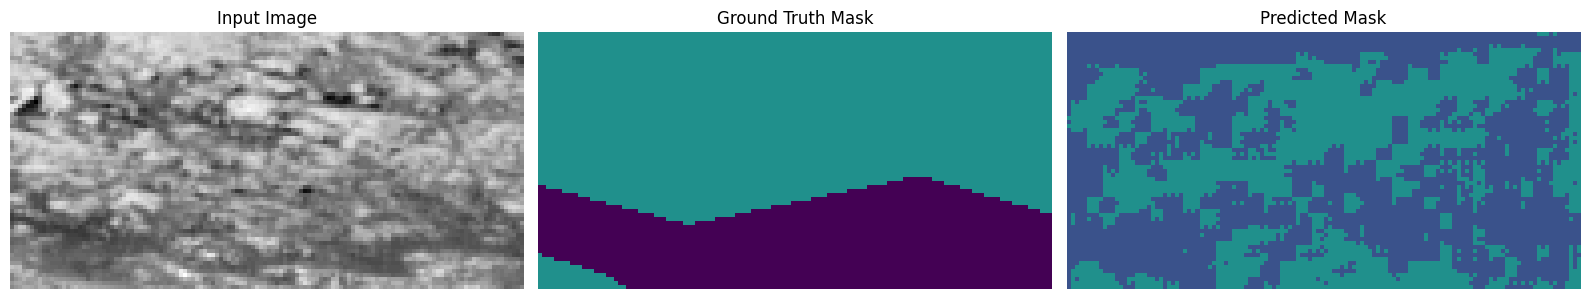

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.4370 - loss: 1.5610 - mean_iou: 0.2974 - val_accuracy: 0.4639 - val_loss: 1.5663 - val_mean_iou: 0.3358
Epoch 22/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.4496 - loss: 1.5676 - mean_iou: 0.3265 - val_accuracy: 0.4731 - val_loss: 1.5500 - val_mean_iou: 0.3095
Epoch 23/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.4691 - loss: 1.5253 - mean_iou: 0.3408 - val_accuracy: 0.3944 - val_loss: 1.6500 - val_mean_iou: 0.2831
Epoch 24/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.4868 - loss: 1.5048 - mean_iou: 0.3593 - val_accuracy: 0.4254 - val_loss: 1.6935 - val_mean_iou: 0.2825
Epoch 25/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.4937 - loss: 1.4648 - mean_iou: 0.3735 - val_accuracy: 0.1989 - val_loss: 2.8438 - val_mean_iou: 0.0657
Epoch 26/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5102 - loss: 1.4307 - mean_iou: 0.3883

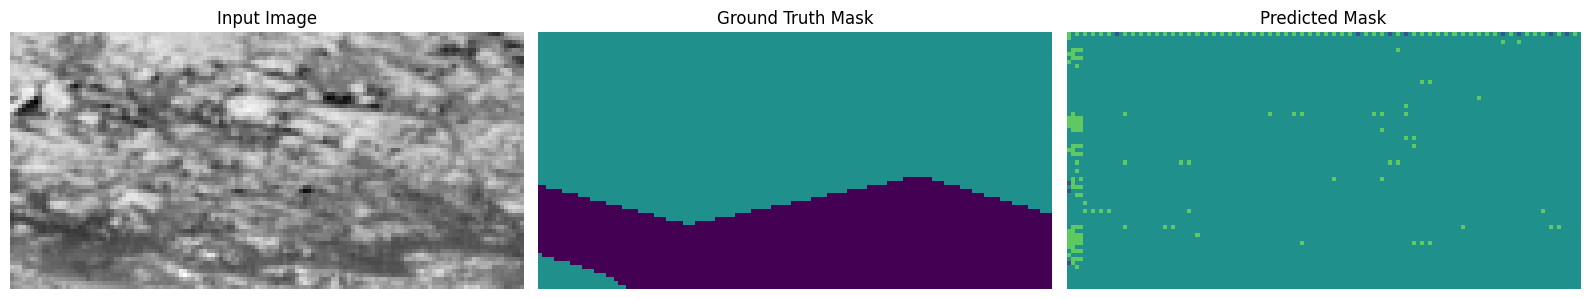

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5102 - loss: 1.4308 - mean_iou: 0.3882 - val_accuracy: 0.1985 - val_loss: 2.2761 - val_mean_iou: 0.0728
Epoch 27/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.5154 - loss: 1.4004 - mean_iou: 0.3961 - val_accuracy: 0.2030 - val_loss: 2.3544 - val_mean_iou: 0.0755
Epoch 28/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5074 - loss: 1.4183 - mean_iou: 0.3889 - val_accuracy: 0.1989 - val_loss: 2.7964 - val_mean_iou: 0.0658
Epoch 29/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5223 - loss: 1.3729 - mean_iou: 0.4044 - val_accuracy: 0.3148 - val_loss: 2.0902 - val_mean_iou: 0.1926
Epoch 30/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5190 - loss: 1.3879 - mean_iou: 0.4018 - val_accuracy: 0.3071 - val_loss: 1.9728 - val_mean_iou: 0.1911
Epoch 31/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5162 - loss: 1.4027 - mean_iou: 0.4006

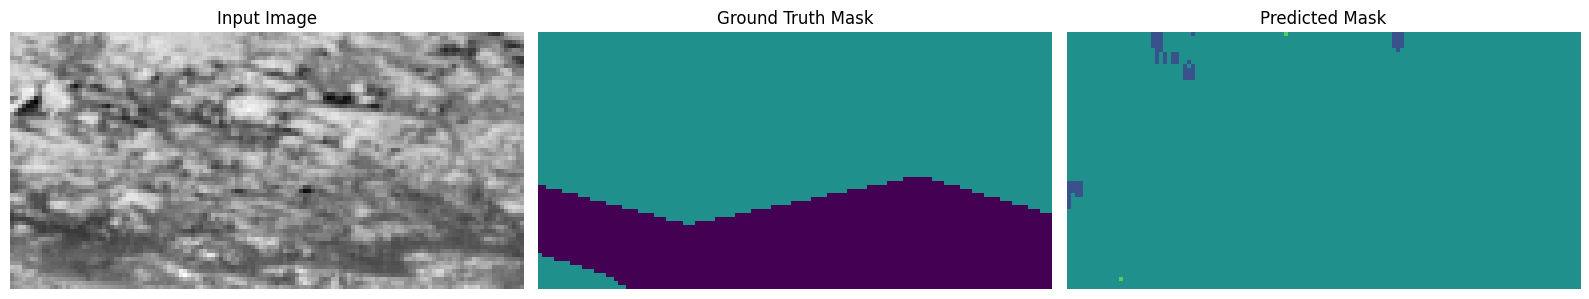

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5165 - loss: 1.4021 - mean_iou: 0.4006 - val_accuracy: 0.3768 - val_loss: 1.7053 - val_mean_iou: 0.2701
Epoch 32/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.5341 - loss: 1.3346 - mean_iou: 0.4218 - val_accuracy: 0.5181 - val_loss: 1.4508 - val_mean_iou: 0.3928
Epoch 33/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5384 - loss: 1.3267 - mean_iou: 0.4267 - val_accuracy: 0.5258 - val_loss: 1.3818 - val_mean_iou: 0.3898
Epoch 34/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5312 - loss: 1.3386 - mean_iou: 0.4208 - val_accuracy: 0.5400 - val_loss: 1.3615 - val_mean_iou: 0.4130
Epoch 35/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5451 - loss: 1.3013 - mean_iou: 0.4342 - val_accuracy: 0.2992 - val_loss: 2.5485 - val_mean_iou: 0.1711
Epoch 36/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5371 - loss: 1.3322 - mean_iou: 0.4222

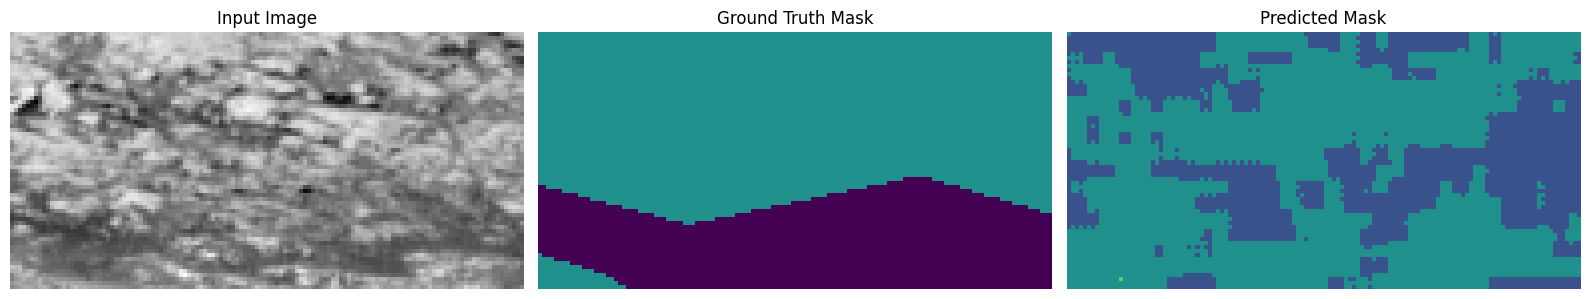

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.5371 - loss: 1.3323 - mean_iou: 0.4221 - val_accuracy: 0.5663 - val_loss: 1.2492 - val_mean_iou: 0.4464
Epoch 37/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5416 - loss: 1.3109 - mean_iou: 0.4336 - val_accuracy: 0.5429 - val_loss: 1.3205 - val_mean_iou: 0.4125
Epoch 38/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5396 - loss: 1.3103 - mean_iou: 0.4272 - val_accuracy: 0.5168 - val_loss: 1.4202 - val_mean_iou: 0.3932
Epoch 39/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5387 - loss: 1.3160 - mean_iou: 0.4280 - val_accuracy: 0.5592 - val_loss: 1.2718 - val_mean_iou: 0.4254
Epoch 40/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5343 - loss: 1.3159 - mean_iou: 0.4240 - val_accuracy: 0.5138 - val_loss: 1.4216 - val_mean_iou: 0.3656
Epoch 41/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5491 - loss: 1.2722 - mean_iou: 0.4405

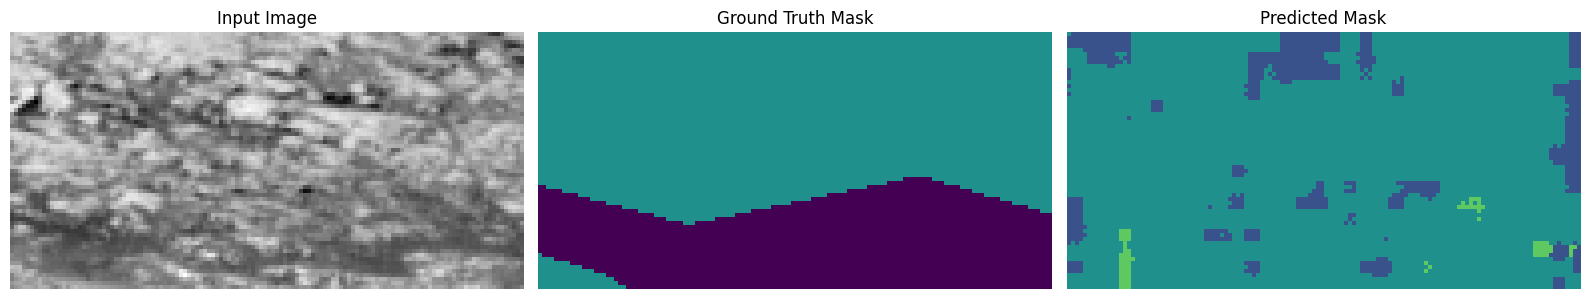

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5492 - loss: 1.2725 - mean_iou: 0.4403 - val_accuracy: 0.4854 - val_loss: 1.5531 - val_mean_iou: 0.3583
Epoch 42/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.5419 - loss: 1.3030 - mean_iou: 0.4273 - val_accuracy: 0.5733 - val_loss: 1.2274 - val_mean_iou: 0.4549
Epoch 43/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5486 - loss: 1.2682 - mean_iou: 0.4415 - val_accuracy: 0.5618 - val_loss: 1.2811 - val_mean_iou: 0.4382
Epoch 44/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5453 - loss: 1.2872 - mean_iou: 0.4334 - val_accuracy: 0.5694 - val_loss: 1.2500 - val_mean_iou: 0.4514
Epoch 45/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5460 - loss: 1.2811 - mean_iou: 0.4396 - val_accuracy: 0.5783 - val_loss: 1.2001 - val_mean_iou: 0.4593
Epoch 46/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5421 - loss: 1.2837 - mean_iou: 0.4365

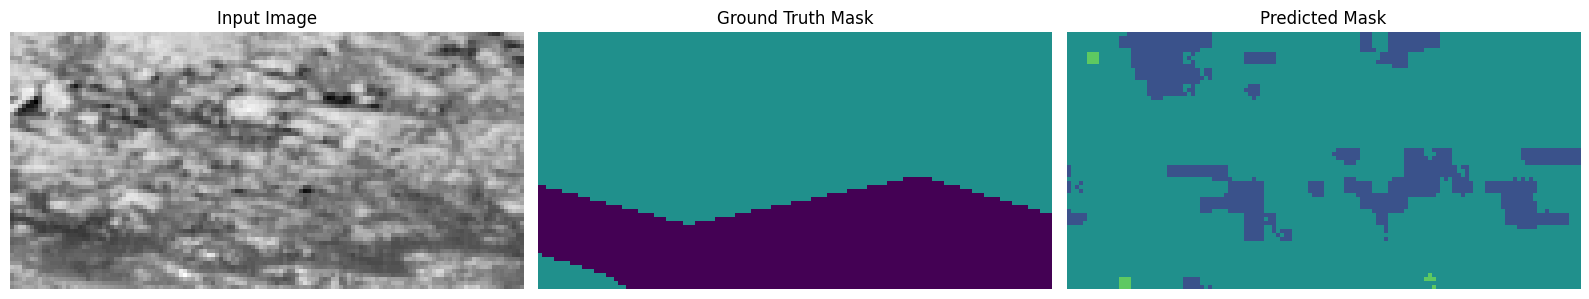

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.5423 - loss: 1.2836 - mean_iou: 0.4364 - val_accuracy: 0.5130 - val_loss: 1.3922 - val_mean_iou: 0.4007
Epoch 47/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5427 - loss: 1.3005 - mean_iou: 0.4278 - val_accuracy: 0.5442 - val_loss: 1.3513 - val_mean_iou: 0.4107
Epoch 48/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5497 - loss: 1.2620 - mean_iou: 0.4426 - val_accuracy: 0.4969 - val_loss: 1.4819 - val_mean_iou: 0.3663
Epoch 49/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5528 - loss: 1.2470 - mean_iou: 0.4419 - val_accuracy: 0.5698 - val_loss: 1.2475 - val_mean_iou: 0.4513
Epoch 50/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5512 - loss: 1.2569 - mean_iou: 0.4440 - val_accuracy: 0.5695 - val_loss: 1.2513 - val_mean_iou: 0.4518
Epoch 51/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5475 - loss: 1.2657 - mean_iou: 0.4412

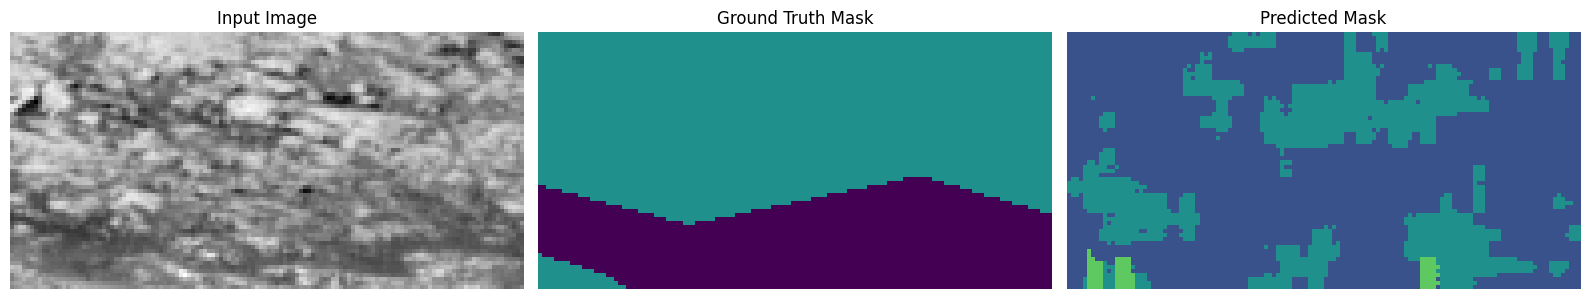

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5477 - loss: 1.2656 - mean_iou: 0.4411 - val_accuracy: 0.5758 - val_loss: 1.2088 - val_mean_iou: 0.4494
Epoch 52/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.5488 - loss: 1.2653 - mean_iou: 0.4437 - val_accuracy: 0.4707 - val_loss: 1.9184 - val_mean_iou: 0.3358
Epoch 53/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5509 - loss: 1.2625 - mean_iou: 0.4396 - val_accuracy: 0.4575 - val_loss: 2.1122 - val_mean_iou: 0.3217
Epoch 54/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5521 - loss: 1.2480 - mean_iou: 0.4451 - val_accuracy: 0.5659 - val_loss: 1.2628 - val_mean_iou: 0.4465
Epoch 55/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5464 - loss: 1.2694 - mean_iou: 0.4359 - val_accuracy: 0.5626 - val_loss: 1.2355 - val_mean_iou: 0.4434
Epoch 56/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5554 - loss: 1.2537 - mean_iou: 0.4494

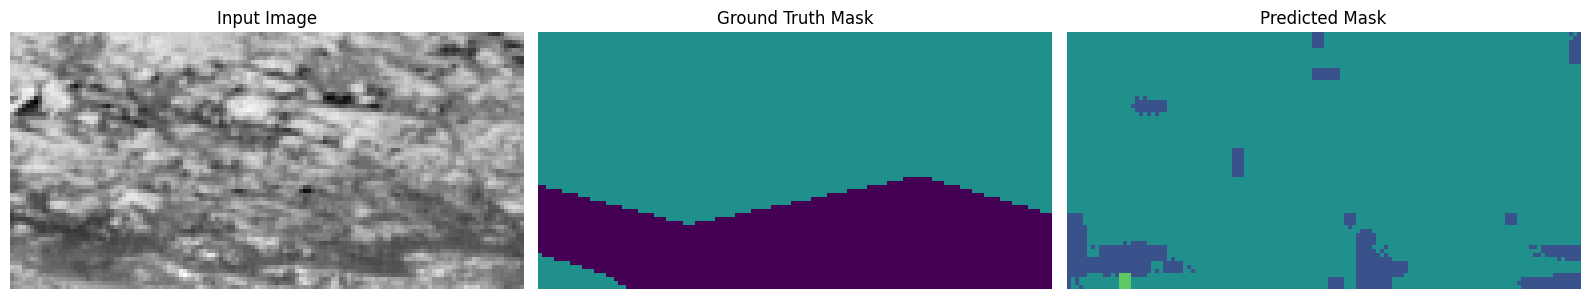

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5554 - loss: 1.2539 - mean_iou: 0.4492 - val_accuracy: 0.4569 - val_loss: 1.7318 - val_mean_iou: 0.3406
Epoch 57/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5525 - loss: 1.2699 - mean_iou: 0.4414 - val_accuracy: 0.4452 - val_loss: 1.5218 - val_mean_iou: 0.3368
Epoch 58/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5519 - loss: 1.2483 - mean_iou: 0.4499 - val_accuracy: 0.5601 - val_loss: 1.2807 - val_mean_iou: 0.4246
Epoch 59/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5548 - loss: 1.2426 - mean_iou: 0.4476 - val_accuracy: 0.5658 - val_loss: 1.2487 - val_mean_iou: 0.4380
Epoch 60/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5572 - loss: 1.2330 - mean_iou: 0.4486 - val_accuracy: 0.4153 - val_loss: 1.7387 - val_mean_iou: 0.2991
Epoch 61/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5487 - loss: 1.2719 - mean_iou: 0.4429

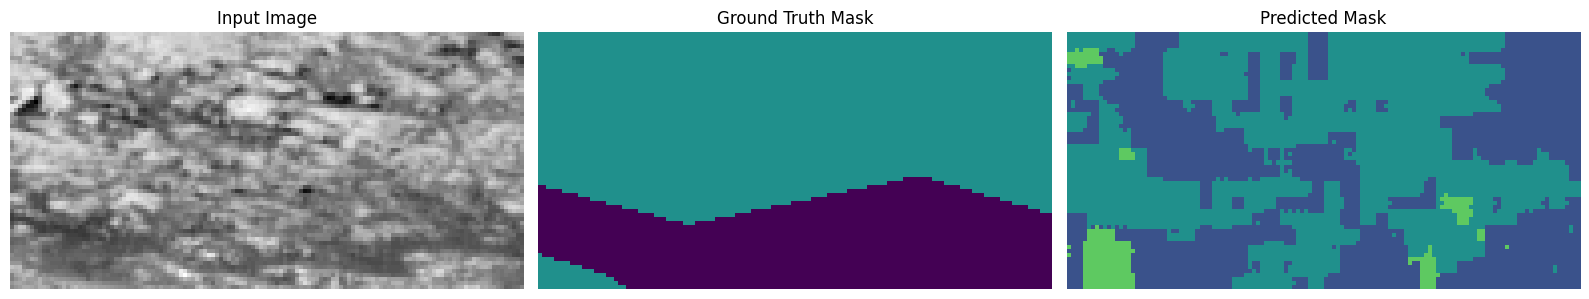

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5488 - loss: 1.2722 - mean_iou: 0.4427 - val_accuracy: 0.5564 - val_loss: 1.2927 - val_mean_iou: 0.4260
Epoch 62/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5565 - loss: 1.2454 - mean_iou: 0.4518 - val_accuracy: 0.5776 - val_loss: 1.2133 - val_mean_iou: 0.4524
Epoch 63/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5553 - loss: 1.2430 - mean_iou: 0.4492 - val_accuracy: 0.4255 - val_loss: 1.6501 - val_mean_iou: 0.3182
Epoch 64/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5629 - loss: 1.2218 - mean_iou: 0.4573 - val_accuracy: 0.5691 - val_loss: 1.2203 - val_mean_iou: 0.4502
Epoch 65/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5584 - loss: 1.2358 - mean_iou: 0.4545 - val_accuracy: 0.5805 - val_loss: 1.1793 - val_mean_iou: 0.4638
Epoch 66/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5646 - loss: 1.2233 - mean_iou: 0.4562

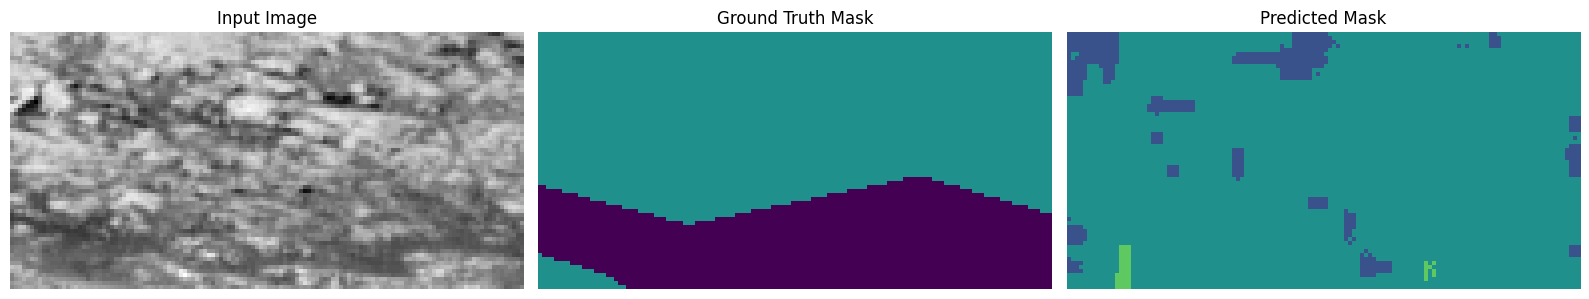

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.5645 - loss: 1.2237 - mean_iou: 0.4560 - val_accuracy: 0.5068 - val_loss: 1.3833 - val_mean_iou: 0.3925
Epoch 67/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5583 - loss: 1.2333 - mean_iou: 0.4529 - val_accuracy: 0.5030 - val_loss: 1.4215 - val_mean_iou: 0.3892
Epoch 68/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.5583 - loss: 1.2389 - mean_iou: 0.4484 - val_accuracy: 0.5892 - val_loss: 1.1597 - val_mean_iou: 0.4737
Epoch 69/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5615 - loss: 1.2153 - mean_iou: 0.4535 - val_accuracy: 0.5242 - val_loss: 1.3410 - val_mean_iou: 0.4128
Epoch 70/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5603 - loss: 1.2219 - mean_iou: 0.4524 - val_accuracy: 0.5895 - val_loss: 1.1584 - val_mean_iou: 0.4702
Epoch 71/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5620 - loss: 1.2276 - mean_iou: 0.4504

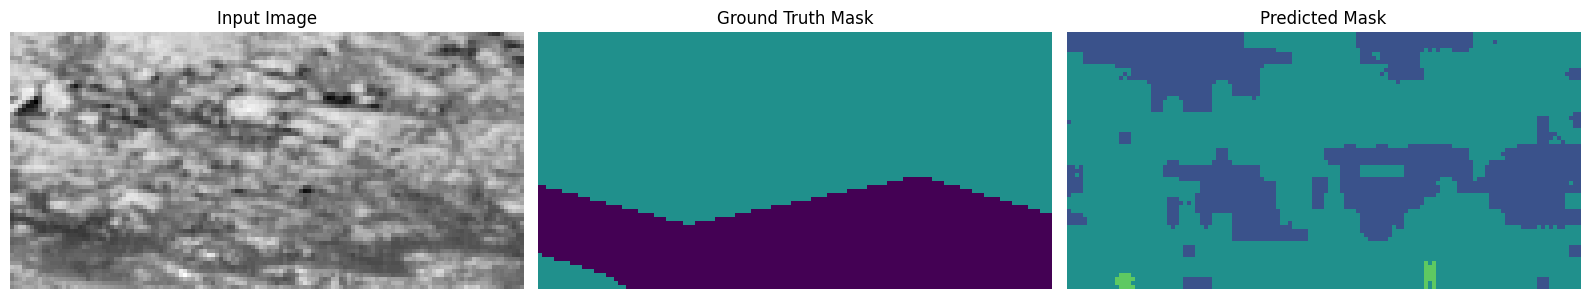

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.5620 - loss: 1.2278 - mean_iou: 0.4504 - val_accuracy: 0.5833 - val_loss: 1.1790 - val_mean_iou: 0.4713
Epoch 72/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5659 - loss: 1.2027 - mean_iou: 0.4654 - val_accuracy: 0.5734 - val_loss: 1.2418 - val_mean_iou: 0.4490
Epoch 73/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5599 - loss: 1.2210 - mean_iou: 0.4555 - val_accuracy: 0.3206 - val_loss: 2.0135 - val_mean_iou: 0.2069
Epoch 74/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5587 - loss: 1.2319 - mean_iou: 0.4568 - val_accuracy: 0.4866 - val_loss: 1.5476 - val_mean_iou: 0.3537
Epoch 75/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5589 - loss: 1.2260 - mean_iou: 0.4518 - val_accuracy: 0.5881 - val_loss: 1.1710 - val_mean_iou: 0.4759
Epoch 76/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5680 - loss: 1.1956 - mean_iou: 0.4599

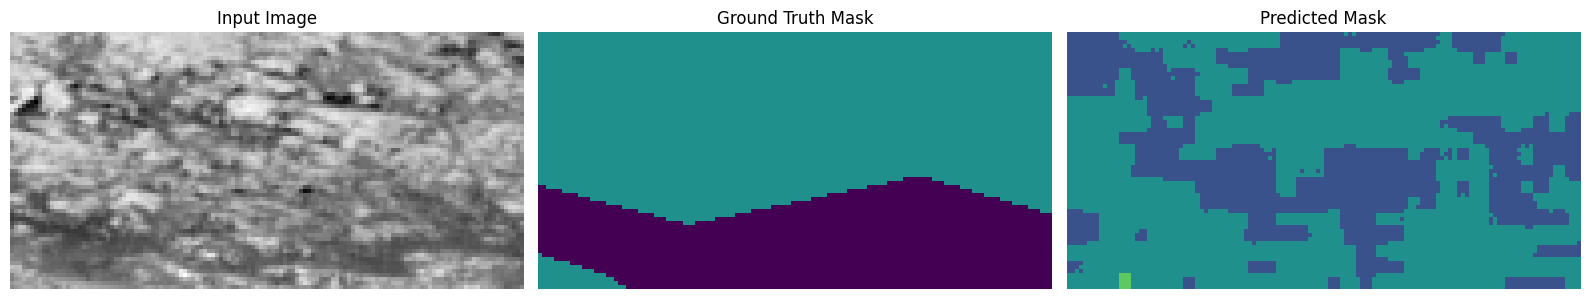

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5680 - loss: 1.1960 - mean_iou: 0.4598 - val_accuracy: 0.5842 - val_loss: 1.2189 - val_mean_iou: 0.4677
Epoch 77/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5611 - loss: 1.2193 - mean_iou: 0.4711 - val_accuracy: 0.5905 - val_loss: 1.1674 - val_mean_iou: 0.4760
Epoch 78/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5521 - loss: 1.2387 - mean_iou: 0.4503 - val_accuracy: 0.5823 - val_loss: 1.2338 - val_mean_iou: 0.4659
Epoch 79/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5557 - loss: 1.2303 - mean_iou: 0.4488 - val_accuracy: 0.5956 - val_loss: 1.1323 - val_mean_iou: 0.4791
Epoch 80/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5618 - loss: 1.2301 - mean_iou: 0.4580 - val_accuracy: 0.5864 - val_loss: 1.1590 - val_mean_iou: 0.4645
Epoch 81/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5625 - loss: 1.2221 - mean_iou: 0.4591

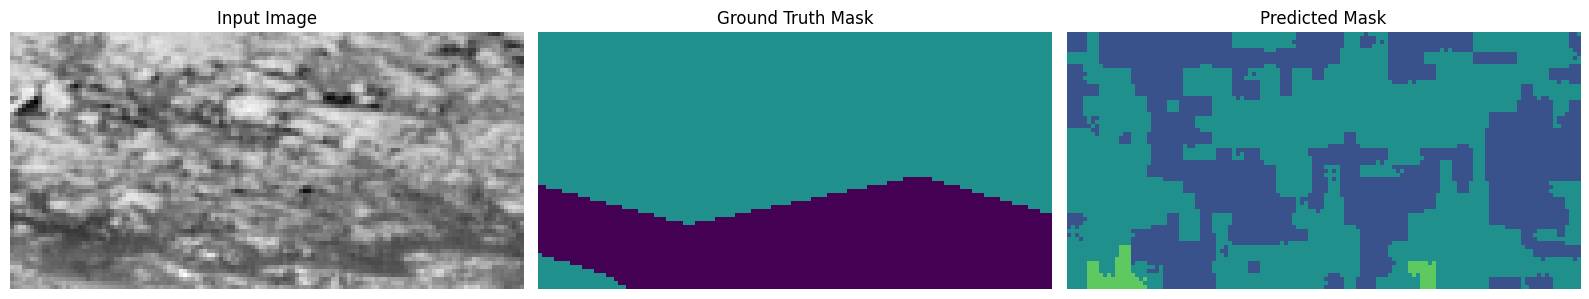

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5626 - loss: 1.2221 - mean_iou: 0.4589 - val_accuracy: 0.5963 - val_loss: 1.1293 - val_mean_iou: 0.4808
Epoch 82/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5650 - loss: 1.2065 - mean_iou: 0.4627 - val_accuracy: 0.5762 - val_loss: 1.2008 - val_mean_iou: 0.4616
Epoch 83/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5639 - loss: 1.2103 - mean_iou: 0.4615 - val_accuracy: 0.5364 - val_loss: 1.3279 - val_mean_iou: 0.4010
Epoch 84/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5676 - loss: 1.2008 - mean_iou: 0.4666 - val_accuracy: 0.5886 - val_loss: 1.1662 - val_mean_iou: 0.4771
Epoch 85/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5617 - loss: 1.2128 - mean_iou: 0.4621 - val_accuracy: 0.4833 - val_loss: 1.5326 - val_mean_iou: 0.3624
Epoch 86/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5615 - loss: 1.2249 - mean_iou: 0.4530

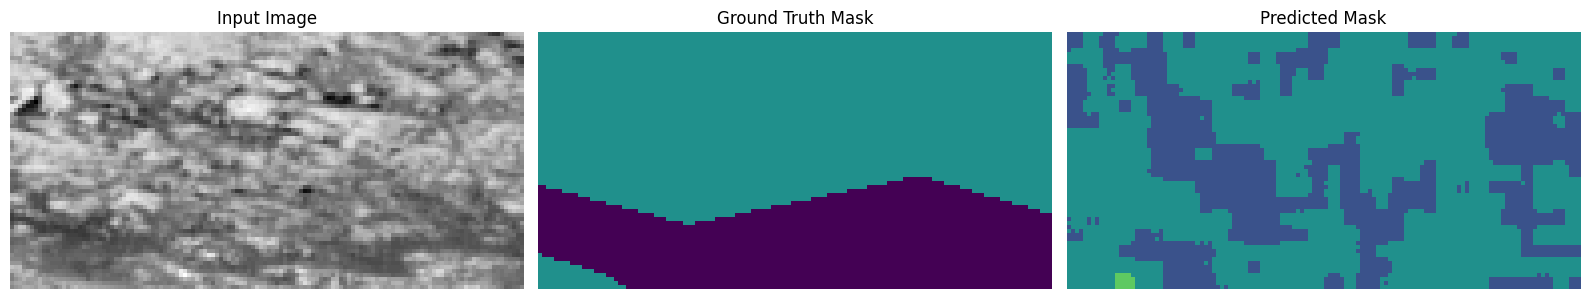

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5616 - loss: 1.2248 - mean_iou: 0.4530 - val_accuracy: 0.5860 - val_loss: 1.1898 - val_mean_iou: 0.4694
Epoch 87/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5676 - loss: 1.2023 - mean_iou: 0.4605 - val_accuracy: 0.5447 - val_loss: 1.2918 - val_mean_iou: 0.4296
Epoch 88/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5647 - loss: 1.2161 - mean_iou: 0.4661 - val_accuracy: 0.5164 - val_loss: 1.3919 - val_mean_iou: 0.4039
Epoch 89/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5599 - loss: 1.2203 - mean_iou: 0.4513 - val_accuracy: 0.5943 - val_loss: 1.1615 - val_mean_iou: 0.4824
Epoch 90/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5613 - loss: 1.2233 - mean_iou: 0.4539 - val_accuracy: 0.5877 - val_loss: 1.1686 - val_mean_iou: 0.4757
Epoch 91/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5695 - loss: 1.2027 - mean_iou: 0.4582

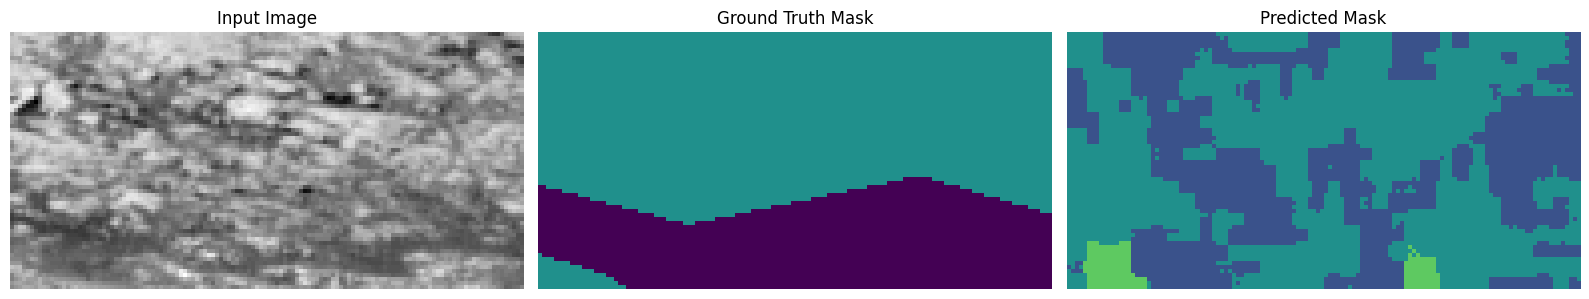

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.5694 - loss: 1.2031 - mean_iou: 0.4581 - val_accuracy: 0.5905 - val_loss: 1.1582 - val_mean_iou: 0.4718
Epoch 92/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5667 - loss: 1.2073 - mean_iou: 0.4597 - val_accuracy: 0.5920 - val_loss: 1.1599 - val_mean_iou: 0.4781
Epoch 93/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5656 - loss: 1.2157 - mean_iou: 0.4567 - val_accuracy: 0.6006 - val_loss: 1.1190 - val_mean_iou: 0.4897
Epoch 94/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.5677 - loss: 1.1904 - mean_iou: 0.4672 - val_accuracy: 0.5020 - val_loss: 1.4184 - val_mean_iou: 0.3907
Epoch 95/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5611 - loss: 1.2144 - mean_iou: 0.4540 - val_accuracy: 0.4990 - val_loss: 1.4627 - val_mean_iou: 0.3837
Epoch 96/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5673 - loss: 1.1921 - mean_iou: 0.4634

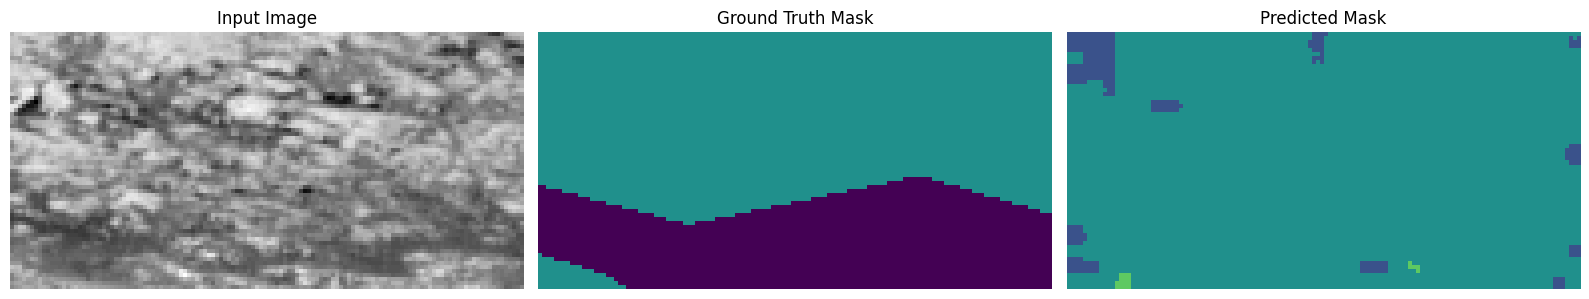

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.5674 - loss: 1.1923 - mean_iou: 0.4633 - val_accuracy: 0.4652 - val_loss: 1.5277 - val_mean_iou: 0.3492
Epoch 97/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.5675 - loss: 1.1957 - mean_iou: 0.4632 - val_accuracy: 0.5837 - val_loss: 1.1943 - val_mean_iou: 0.4652
Epoch 98/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5655 - loss: 1.2094 - mean_iou: 0.4631 - val_accuracy: 0.5967 - val_loss: 1.1368 - val_mean_iou: 0.4837
Epoch 99/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5732 - loss: 1.1727 - mean_iou: 0.4732 - val_accuracy: 0.5818 - val_loss: 1.2029 - val_mean_iou: 0.4700
Epoch 100/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5637 - loss: 1.2119 - mean_iou: 0.4568 - val_accuracy: 0.5939 - val_loss: 1.1531 - val_mean_iou: 0.4827
Epoch 101/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5635 - loss: 1.2044 - mean_iou: 0.4603

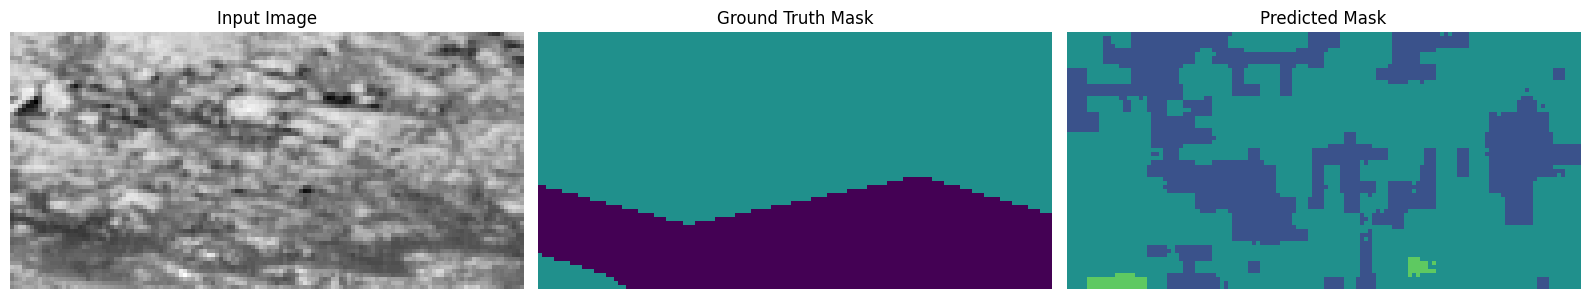

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.5637 - loss: 1.2044 - mean_iou: 0.4603 - val_accuracy: 0.5977 - val_loss: 1.1298 - val_mean_iou: 0.4849
Epoch 102/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5664 - loss: 1.1971 - mean_iou: 0.4605 - val_accuracy: 0.5984 - val_loss: 1.1218 - val_mean_iou: 0.4848
Epoch 103/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5653 - loss: 1.1962 - mean_iou: 0.4641 - val_accuracy: 0.5840 - val_loss: 1.1895 - val_mean_iou: 0.4675
Epoch 104/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.5643 - loss: 1.2026 - mean_iou: 0.4580 - val_accuracy: 0.5456 - val_loss: 1.3370 - val_mean_iou: 0.4308
Epoch 105/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.5642 - loss: 1.2054 - mean_iou: 0.4576 - val_accuracy: 0.5939 - val_loss: 1.1429 - val_mean_iou: 0.4793
Epoch 106/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5681 - loss: 1.1860 - mean_iou: 0.4681

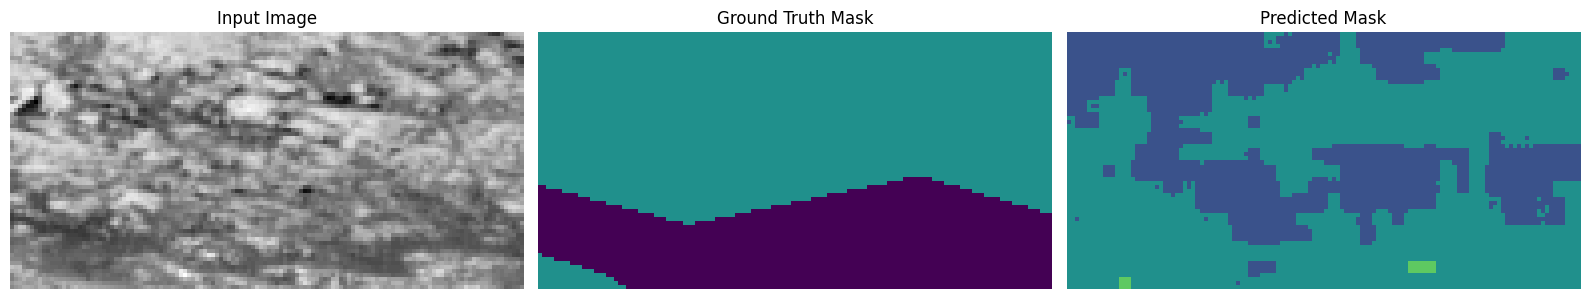

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.5682 - loss: 1.1865 - mean_iou: 0.4678 - val_accuracy: 0.5877 - val_loss: 1.1886 - val_mean_iou: 0.4722
Epoch 107/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.5528 - loss: 1.2459 - mean_iou: 0.4456 - val_accuracy: 0.5949 - val_loss: 1.1485 - val_mean_iou: 0.4837
Epoch 108/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5627 - loss: 1.2037 - mean_iou: 0.4578 - val_accuracy: 0.5887 - val_loss: 1.1681 - val_mean_iou: 0.4770
Epoch 109/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5661 - loss: 1.2048 - mean_iou: 0.4603 - val_accuracy: 0.5987 - val_loss: 1.1264 - val_mean_iou: 0.4837
Epoch 110/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5647 - loss: 1.1962 - mean_iou: 0.4664 - val_accuracy: 0.5888 - val_loss: 1.1599 - val_mean_iou: 0.4769
Epoch 111/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5701 - loss: 1.1809 - mean_iou: 0.4716

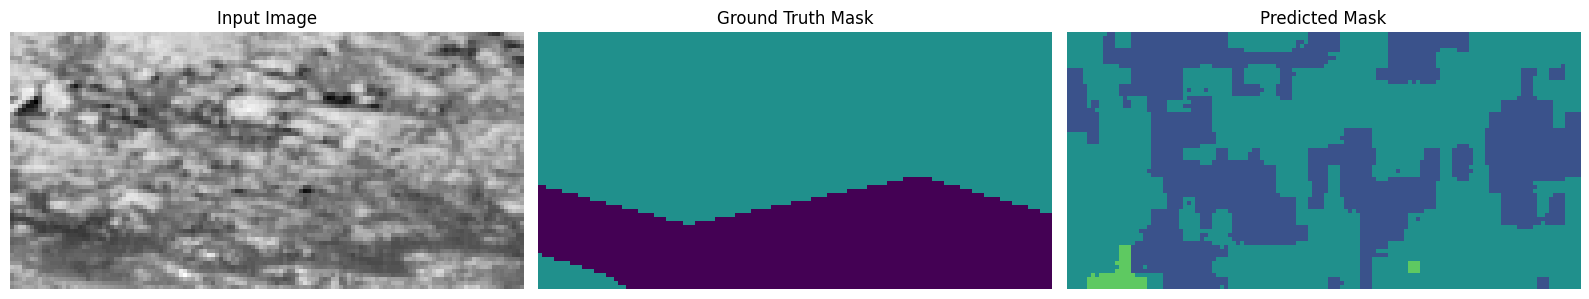

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5702 - loss: 1.1812 - mean_iou: 0.4713 - val_accuracy: 0.5949 - val_loss: 1.1426 - val_mean_iou: 0.4807
Epoch 112/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5682 - loss: 1.1979 - mean_iou: 0.4618 - val_accuracy: 0.5674 - val_loss: 1.2496 - val_mean_iou: 0.4536
Epoch 113/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5702 - loss: 1.1930 - mean_iou: 0.4656 - val_accuracy: 0.5863 - val_loss: 1.1781 - val_mean_iou: 0.4743
Epoch 114/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5666 - loss: 1.1945 - mean_iou: 0.4612 - val_accuracy: 0.5429 - val_loss: 1.3086 - val_mean_iou: 0.4318
Epoch 115/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5665 - loss: 1.1946 - mean_iou: 0.4629 - val_accuracy: 0.5906 - val_loss: 1.1638 - val_mean_iou: 0.4803
Epoch 116/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5606 - loss: 1.2159 - mean_iou: 0.4569

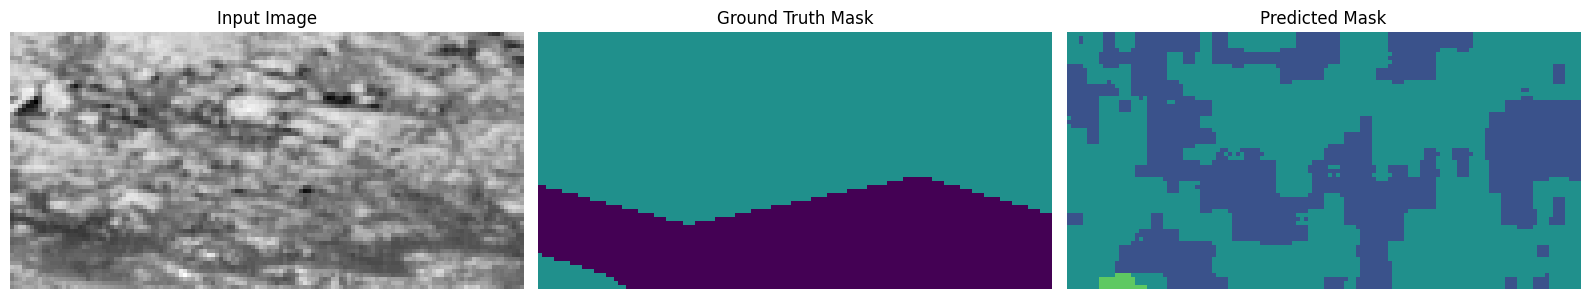

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5609 - loss: 1.2158 - mean_iou: 0.4569 - val_accuracy: 0.5945 - val_loss: 1.1455 - val_mean_iou: 0.4795
Epoch 117/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5629 - loss: 1.2064 - mean_iou: 0.4680 - val_accuracy: 0.5871 - val_loss: 1.1913 - val_mean_iou: 0.4734
Epoch 118/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5690 - loss: 1.1922 - mean_iou: 0.4635 - val_accuracy: 0.5705 - val_loss: 1.2407 - val_mean_iou: 0.4489
Epoch 119/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.5587 - loss: 1.2184 - mean_iou: 0.4533 - val_accuracy: 0.5751 - val_loss: 1.2273 - val_mean_iou: 0.4602
Epoch 120/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.5702 - loss: 1.1881 - mean_iou: 0.4731 - val_accuracy: 0.5922 - val_loss: 1.1649 - val_mean_iou: 0.4800
Epoch 121/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5631 - loss: 1.1960 - mean_iou: 0.4606

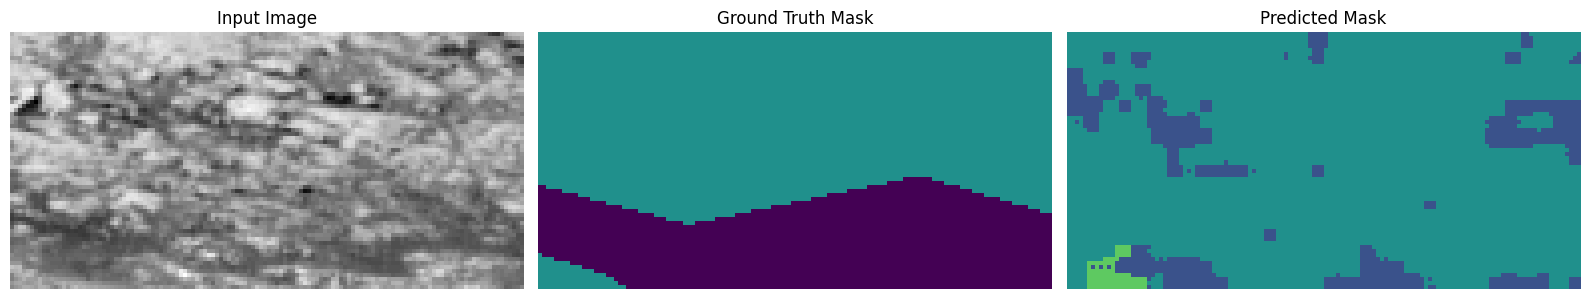

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.5634 - loss: 1.1959 - mean_iou: 0.4606 - val_accuracy: 0.5690 - val_loss: 1.2359 - val_mean_iou: 0.4555
Epoch 122/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5616 - loss: 1.2058 - mean_iou: 0.4615 - val_accuracy: 0.5989 - val_loss: 1.1350 - val_mean_iou: 0.4853
Epoch 123/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.5662 - loss: 1.1792 - mean_iou: 0.4657 - val_accuracy: 0.5714 - val_loss: 1.2141 - val_mean_iou: 0.4593
Final validation Mean Intersection Over Union: 48.97%


In [12]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [13]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_MultiResNet_{timestep_str}_{str(final_val_meanIoU)}.keras"
model.save(model_filename)


In [14]:
del model

print(f"Model saved to {model_filename}")

Model saved to model_MultiResNet_241213_192950_48.97.keras


## Results

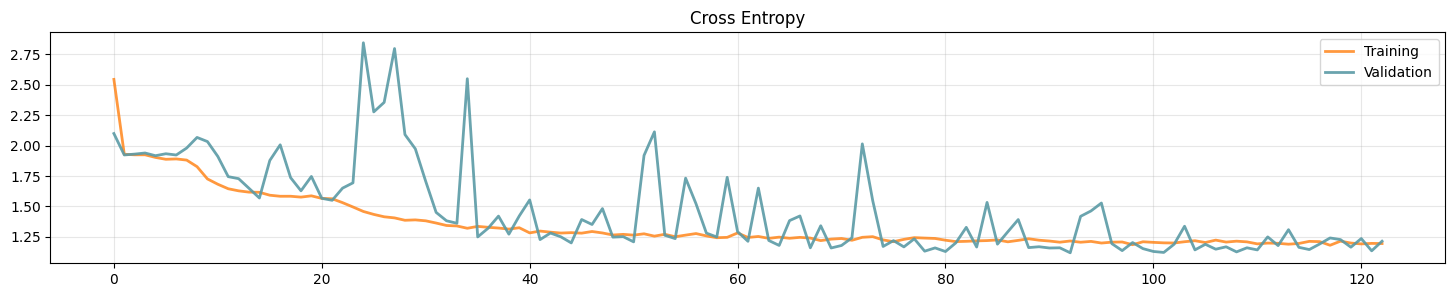

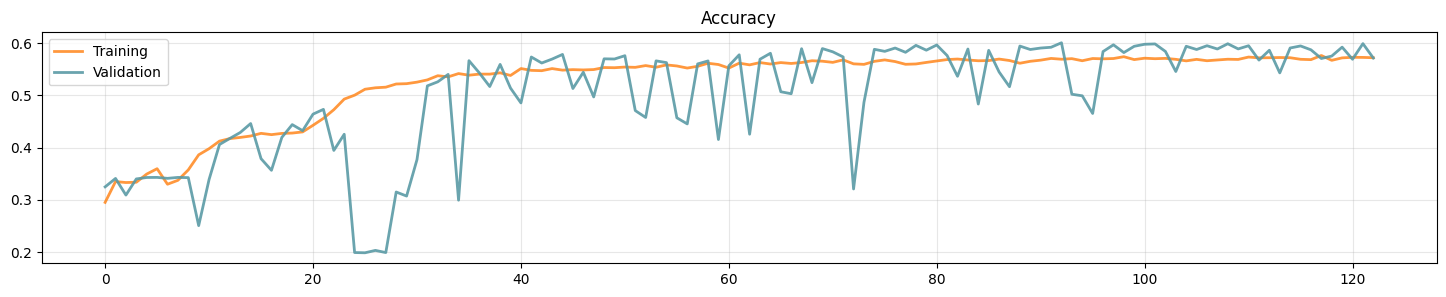

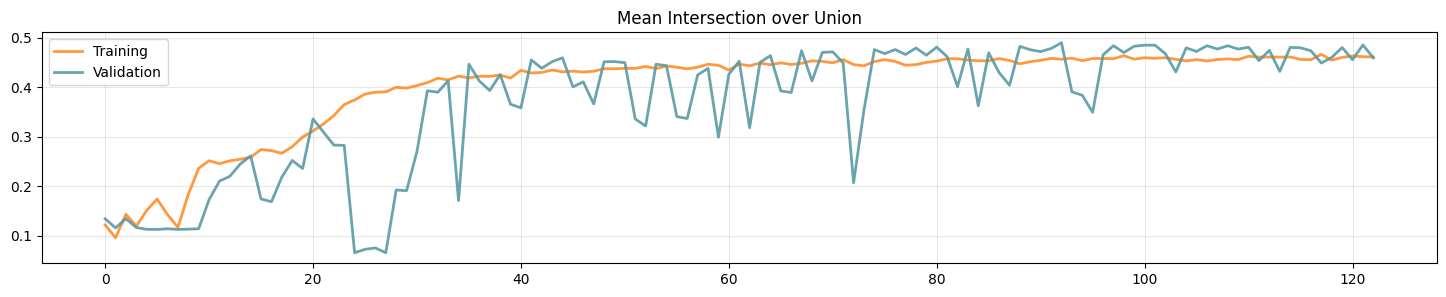

In [15]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [16]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [17]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_MultiResNet_241213_192950_48.97.keras


In [18]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes

preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")


I0000 00:00:1734118214.324760    3837 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_109', 256 bytes spill stores, 256 bytes spill loads



313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

I0000 00:00:1734118244.915123    3871 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_109', 256 bytes spill stores, 256 bytes spill loads



314/314 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step
Predictions shape: (10022, 64, 128, 5)
Predictions shape: (10022, 64, 128)


In [19]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [20]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

#from google.colab import files
#files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

In [21]:
import time
import numpy as np
import sounddevice as sd

def generate_noise(duration=1, sample_rate=44100):
    """Génère un bruit blanc de la durée spécifiée."""
    samples = np.random.uniform(-1, 1, size=(duration * sample_rate,))
    return samples

# Paramètres
sample_rate = 44100  # Fréquence d'échantillonnage en Hz

try:
    print("Le bruit infini est en cours... Interrompez l'exécution pour arrêter.")
    while True:
        noise = generate_noise(duration=1, sample_rate=sample_rate)
        sd.play(noise, samplerate=sample_rate)
        time.sleep(1)  # Attendre la fin de chaque segment avant de continuer
except KeyboardInterrupt:
    print("Exécution interrompue.")
    sd.stop()


ModuleNotFoundError: No module named 'sounddevice'